In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from taurex.log.logger import root_logger
%matplotlib inline

In [2]:
from taurex.parameter import ParameterParser

pp = ParameterParser()

# Parse the input file
# input_file = "parfile.par"
input_file = "parfile-gpu.par"
pp.read(input_file)

# Setup global parameters
pp.setup_globals()

# Get the spectrum
observation = pp.generate_observation()

binning = pp.generate_binning()

# Generate a model from the input
model = pp.generate_appropriate_model(obs=observation)

# build the model
model.build()

taurex.ParamParser - INFO - Interpolation mode set to linear
taurex.ParamParser - WARNING - Xsecs will be loaded in memory
taurex.ParamParser - WARNING - Radis is disabled
taurex.ParamParser - WARNING - Radis default grid will be used
taurex.ClassFactory - INFO - Reloading all modules and plugins
taurex.ClassFactory - INFO - ----------Plugin loading---------
taurex.ClassFactory - INFO - Loading ace
taurex.ClassFactory - INFO - Loading cuda
taurex.ClassFactory - INFO - Loading curvefit
taurex.ClassFactory - INFO - Loading emcee
taurex.ClassFactory - INFO - Loading petitrad
taurex.ClassFactory - INFO - Loading ultranest
taurex.TransmissionCudaModel - INFO - No pressure profile defined, using simple pressure profile with
taurex.TransmissionCudaModel - INFO - parameters nlayers: 100, atm_pressure_range=(0.0001,1000000.0)
taurex.TransmissionCudaModel - INFO - Building model........
taurex.TransmissionCudaModel - INFO - Collecting paramters
taurex.TransmissionCudaModel - INFO - Setting up pr

In [3]:
wngrid = None

if binning == "observed" and observation is None:
    root_logger.critical(
        "Binning selected from Observation yet None provided"
    )
    quit()

if binning is None:
    if observation is None or observation == "self":
        binning = model.defaultBinner()
        wngrid = model.nativeWavenumberGrid
    else:
        binning = observation.create_binner()
        wngrid = observation.wavenumberGrid
else:
    if binning == "native":
        binning = model.defaultBinner()
        wngrid = model.nativeWavenumberGrid
    elif binning == "observed":
        binning = observation.create_binner()
        wngrid = observation.wavenumberGrid
    else:
        binning, wngrid = binning

In [4]:
instrument = pp.generate_instrument(binner=binning)

num_obs = 1
if instrument is not None:
    instrument, num_obs = instrument

if observation == "self" and instrument is None:
    root_logger.critical("Instrument nust be specified when using self option")
    raise ValueError("No instruemnt specified for self option")

inst_result = None
if instrument is not None:
    inst_result = instrument.model_noise(
        model, model_res=model.model(), num_observations=num_obs
    )

taurex.TransmissionCudaModel - INFO - Computing pressure profile
taurex.ChemistryModel - INFO - Initializing chemistry model
taurex.Absorption - INFO - Recomputing active gas CO2 opacity
taurex.CudaOpacity - INFO - Transfering xsec grid to GPU
taurex.CudaOpacity - INFO - Moving to GPU once
taurex.Absorption - INFO - Recomputing active gas CH4 opacity
taurex.CudaOpacity - INFO - Transfering xsec grid to GPU
taurex.CudaOpacity - INFO - Moving to GPU once
taurex.Absorption - INFO - Done
taurex.CIACache - INFO - Loading cia H2-He into model
taurex.CIACache - INFO - Loading cia H2-H2 into model
taurex.CIA - INFO - Done
taurex.Rayleigh - INFO - Done


In [5]:
# Observation on self
if observation == "self":
    from taurex.data.spectrum import ArraySpectrum
    from taurex.util.util import wnwidth_to_wlwidth

    inst_wngrid, inst_spectrum, inst_noise, inst_width = inst_result

    inst_wlgrid = 10000 / inst_wngrid

    inst_wlwidth = wnwidth_to_wlwidth(inst_wngrid, inst_width)
    observation = ArraySpectrum(
        np.vstack([inst_wlgrid, inst_spectrum, inst_noise, inst_wlwidth]).T
    )
    binning = observation.create_binner()

In [6]:
optimizer = None
solution = None

import time

if observation is None:
    root_logger.critical("No spectrum is defined!!")
    quit()

optimizer = pp.generate_optimizer()
optimizer.set_model(model)
optimizer.set_observed(observation)
pp.setup_optimizer(optimizer)

taurex.ParamParser - INFO - Setting up optimizer
taurex.ParamParser - INFO - Fitting: planet_radius
taurex.ParamParser - INFO - Fitting: T
taurex.ParamParser - INFO - Fitting: CO2
taurex.ParamParser - INFO - Fitting: CH4


In [7]:
start_time = time.time()
solution = optimizer.fit()

end_time = time.time()

root_logger.info("Total Retrieval finish in %s seconds", end_time - start_time)

for _, optimized, _, _ in optimizer.get_solution():
    optimizer.update_model(optimized)
    break

result = model.model()

taurex.Emcee - INFO - Initializing parameters
taurex.Emcee - INFO - -------FITTING---------------
taurex.Emcee - INFO - Parameters to be fit:
taurex.Emcee - INFO - planet_radius: Value: 0.5 Type:Uniform Params:Bounds = [0.45,0.55]
taurex.Emcee - INFO - T: Value: 1000.0 Type:Uniform Params:Bounds = [900.0,1100.0]
taurex.Emcee - INFO - CO2: Value: 0.0001 Type:LogUniform Params:Bounds = [-12.0,-1.0]
taurex.Emcee - INFO - CH4: Value: 0.0001 Type:LogUniform Params:Bounds = [-12.0,-1.0]
taurex.Emcee - INFO - 
taurex.Emcee - INFO - -------------------------------------
taurex.Emcee - INFO - ------Retrieval Parameters-----------
taurex.Emcee - INFO - -------------------------------------
taurex.Emcee - INFO - 
taurex.Emcee - INFO - Dimensionality of fit: 4
taurex.Emcee - INFO - 
taurex.Emcee - INFO - 
Param            Value  Type        Args
-------------  -------  ----------  -----------------------
planet_radius      0.5  Uniform     Bounds = [0.45,0.55]
T               1000    Uniform     B

[autoemcee] finding starting points and running initial 100 MCMC steps


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]

[autoemcee] rhat chain diagnostic: [1.29948991 1.35005165 1.2648493  1.25088209] (<1.010 is good)
[autoemcee] not converged yet at iteration 1 after 1816 evals
[autoemcee] Running 200 MCMC steps ...
[autoemcee] Starting points chosen: {5}, L=-2656.1
[autoemcee] Starting at [0.50155868 0.29951435 0.73175664 0.7295726 ] +- [2.07316967e-05 1.95106273e-03 2.15082485e-04 1.41191717e-04]



100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [01:28<00:00,  2.27it/s]

[autoemcee] Starting points chosen: {4}, L=-2656.1
[autoemcee] Starting at [0.49896974 0.95062315 0.68651548 0.70419042] +- [0.00024095 0.01206181 0.0017155  0.00262025]



100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [01:27<00:00,  2.28it/s]

[autoemcee] Used 4832 calls in last MCMC run
[autoemcee] rhat chain diagnostic: [1.03861042 1.11989315 1.14887417 1.12795048] (<1.010 is good)
[autoemcee] not converged yet at iteration 2 after 6648 evals
[autoemcee] Running 400 MCMC steps ...
[autoemcee] Starting points chosen: {2}, L=-2656.1
[autoemcee] Starting at [0.50044448 0.4670975  0.72607207 0.72546587] +- [1.44640724e-05 9.45368002e-04 1.16133036e-04 1.45492841e-05]



100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [02:53<00:00,  2.30it/s]

[autoemcee] Starting points chosen: {7}, L=-2656.1
[autoemcee] Starting at [0.49992209 0.53978566 0.72218774 0.72585682] +- [1.04131342e-05 1.25879893e-03 1.65853827e-04 8.47646736e-05]



100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [02:53<00:00,  2.30it/s]

[autoemcee] Used 9632 calls in last MCMC run
[autoemcee] rhat chain diagnostic: [1.00378234 1.02887037 1.02722475 1.0225528 ] (<1.010 is good)
[autoemcee] not converged yet at iteration 3 after 16280 evals
[autoemcee] Running 800 MCMC steps ...
[autoemcee] Starting points chosen: {4}, L=-2656.1
[autoemcee] Starting at [0.50017916 0.37760545 0.7399924  0.7328286 ] +- [7.93067988e-06 1.34987117e-03 3.00956367e-04 1.59212525e-04]



100%|█████████████████████████████████████████████████████████████████████████████████| 800/800 [05:49<00:00,  2.29it/s]

[autoemcee] Starting points chosen: {4}, L=-2656.1
[autoemcee] Starting at [0.50077536 0.47452216 0.71904538 0.72308628] +- [1.58826252e-05 1.58216012e-03 2.94652435e-04 1.17993914e-04]



100%|█████████████████████████████████████████████████████████████████████████████████| 800/800 [05:48<00:00,  2.29it/s]

[autoemcee] Used 19232 calls in last MCMC run
[autoemcee] rhat chain diagnostic: [1.00320846 1.00373857 1.00746311 1.00648991] (<1.010 is good)
[autoemcee] converged!!!



taurex.Emcee - INFO - Sampling time 1935.527314901352 s
taurex.Emcee - INFO - Post-processing - Generating spectra and profiles
taurex.Emcee - INFO - Computing solution 0
taurex.TransmissionCudaModel - INFO - Computing pressure profile
taurex.ChemistryModel - INFO - Initializing chemistry model
taurex.Absorption - INFO - Recomputing active gas CO2 opacity
taurex.Absorption - INFO - Recomputing active gas CH4 opacity
taurex.Absorption - INFO - Done
taurex.CIA - INFO - Done
taurex.Rayleigh - INFO - Done
taurex.TransmissionCudaModel - INFO - Computing pressure profile
taurex.ChemistryModel - INFO - Initializing chemistry model
taurex.Absorption - INFO - Recomputing active gas CO2 opacity
taurex.Absorption - INFO - Recomputing active gas CH4 opacity
taurex.Absorption - INFO - Done
taurex.CIA - INFO - Done
taurex.Rayleigh - INFO - Done
taurex.TransmissionCudaModel - INFO - Computing pressure profile
taurex.ChemistryModel - INFO - Initializing chemistry model
taurex.TransmissionCudaModel - 

# Let's plot

In [8]:
modelAxis = {
    "TransmissionModel": "$(R_p/R_*)^2$",
    "TransmissionCudaModel": "$(R_p/R_*)^2$",
    "EmissionModel": "$F_p/F_*$",
    "EmissionCudaModel": "$F_p/F_*$",
    "DirectImageModel": "$F_p$",
    "DirectImageCudaModel": "$F_p$",
}

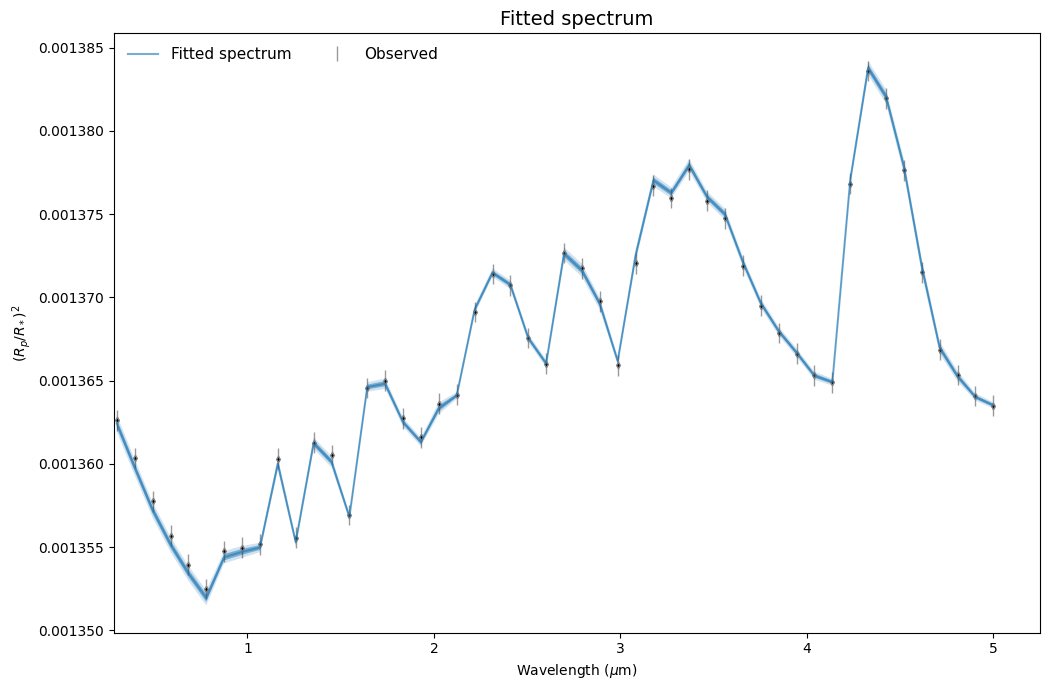

In [9]:
fig = plt.figure(figsize=(10.6, 7.0))

obs_spectrum = optimizer._observed.spectrum
error = optimizer._observed.errorBar
wlgrid = optimizer._observed.wavelengthGrid

plt.errorbar(
    wlgrid,
    obs_spectrum,
    error,
    lw=1,
    color="black",
    alpha=0.4,
    ls="none",
    zorder=0,
    label="Observed",
)

for solution_idx, solution_val in solution.items():
    binned_grid = solution_val["Spectra"]["binned_wlgrid"][...]
    native_grid = solution_val["Spectra"]["native_wngrid"][...]

    plt.scatter(
        wlgrid,
        obs_spectrum,
        marker="d",
        zorder=1,
        **{"s": 10, "edgecolors": "grey", "color": "black"}
    )

    binned_spectrum = solution_val["Spectra"]["binned_spectrum"][...]
    binned_error = solution_val["Spectra"]["binned_std"][...]

    color = "C0"
    label = "Fitted spectrum"
    plt.plot(wlgrid, binned_spectrum, label=label, color=color, alpha=0.6)
    if binned_error is not None:
        # 1 sigma
        plt.fill_between(
            wlgrid,
            binned_spectrum - binned_error,
            binned_spectrum + binned_error,
            alpha=0.5,
            zorder=-2,
            color=color,
            edgecolor="none",
        )

        # 2 sigma
        plt.fill_between(
            wlgrid,
            binned_spectrum - 2 * binned_error,
            binned_spectrum + 2 * binned_error,
            alpha=0.2,
            zorder=-3,
            color=color,
            edgecolor="none",
        )


plt.xlim(np.min(wlgrid) - 0.05 * np.min(wlgrid), np.max(wlgrid) + 0.05 * np.max(wlgrid))
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel(modelAxis[model.__class__.__name__])

if np.max(wlgrid) - np.min(wlgrid) > 5:
    plt.xscale("log")
    plt.tick_params(axis="x", which="minor")
plt.legend(loc="best", ncol=2, frameon=False, prop={"size": 11})

plt.title("Fitted spectrum", fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
def get_derived_parameters(solution):
    if 'derived_params' in solution:
        return [c for k, c in solution['derived_params'].items()]
    else:
        return [solution['fit_params']['mu_derived']]

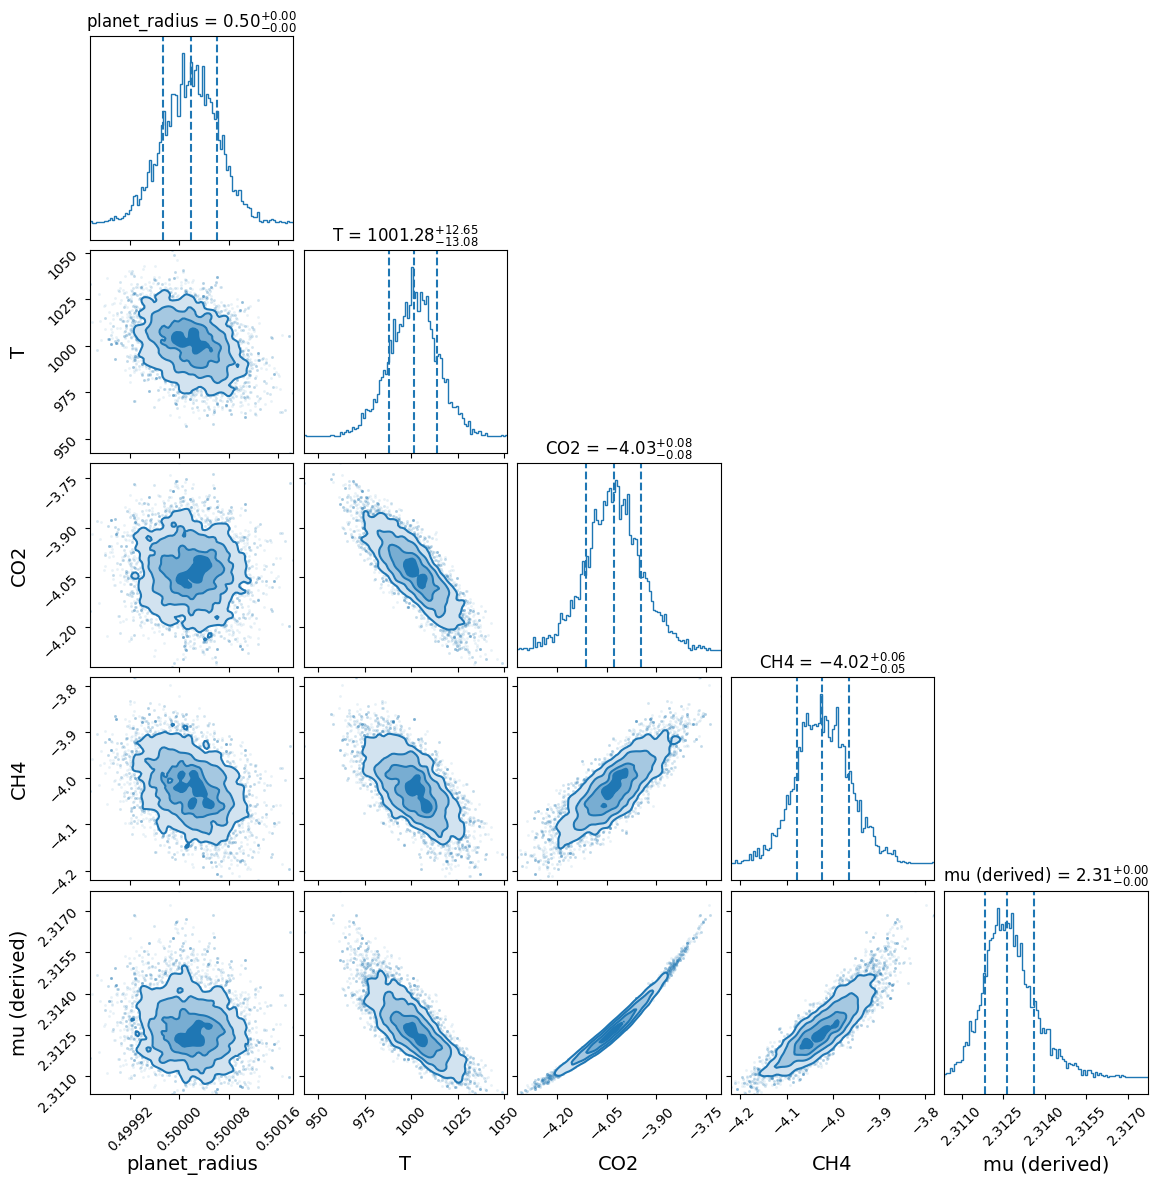

In [11]:
fittingNames = [param[0] for param in optimizer.fitting_parameters]

figs = []
fig = plt.figure(figsize=(12, 12))

for solution_idx, solution_val in solution.items():
    tracedata = solution_val["tracedata"]
    weights = solution_val["weights"]
    indices = np.array([fittingNames.index(x) for x in fittingNames])

    mu_derived = get_derived_parameters(solution_val)
    _tracedata = np.column_stack((tracedata, mu_derived[0]["trace"]))
    fittingNames.append("mu (derived)")

    figure_past = fig

    plt.rc("xtick", labelsize=10)  # size of individual labels
    plt.rc("ytick", labelsize=10)
    plt.rc("axes.formatter", limits=(-4, 5))  # scientific notation..

    fig = corner.corner(
        _tracedata,
        weights=weights,
        labels=fittingNames,
        label_kwargs=dict(fontsize=14),
        smooth=1.5,
        scale_hist=True,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs=dict(fontsize=12),
        # truths=truths,
        truth_color="black",
        ret=True,
        fill_contours=True,
        color=color,
        top_ticks=False,
        bins=100,
        fig=figure_past,
    )
    # fig.gca().annotate(
    #     "Posterior %s" % (solution_idx),
    #     xy=(0.5, 0.96),
    #     xycoords="figure fraction",
    #     xytext=(0, -5),
    #     textcoords="offset points",
    #     ha="center",
    #     va="top",
    #     fontsize=20,
    # )
plt.show()